# GNN Training and Label Propogation

## Table of Contents

### Still WIP

1. Generate Graph Dataset 
2. Label Propogation
3. Train GNN
4. GNN ROC

By: Edward Zhang

In [3]:
'''import pandas as pd
import pickle
df = pd.read_pickle('DataSplit.pkl')
for basename in df.ID.unique():
    minidf = df.loc[(df['ID'] == basename)]
    with open(basename+'.pkl', 'wb') as pickle_file:
        pickle.dump(minidf, pickle_file)
'''

"import pandas as pd\nimport pickle\ndf = pd.read_pickle('DataSplit.pkl')"

In [3]:
'''!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html
!pip install torch-geometric'''

'!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html\n!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html\n!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html\n!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.8.0+cu102.html\n!pip install torch-geometric'

In [7]:
#!pip install torch==1.8.0
#!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
#!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
#!pip install torch-geometric
#!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
#!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html
#pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://pytorch-geometric.com/whl/torch-1.9.0+cu102.html

In [5]:
#!nvidia-smi --gpu-reset
#!nvidia-smi

# 1. Generate Graph Dataset

In [6]:
import torch
import os
import sys
import umap, numba
import numpy as np
import glob, pandas as pd
import pickle
import fire
import torch_geometric
import scipy.sparse as sps
from sklearn.preprocessing import LabelEncoder
from torch_cluster import knn_graph
from torch_geometric.data import Data 
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import InMemoryDataset,DataLoader
from torch_cluster import radius_graph
from torch_geometric.utils import subgraph

# for this program, we're going to create a pseudo whole slide label, you may need to make train, test splits consistent with this label and make sure graphs within patient are assigned to same fold
# we will use folds from before just for this example, but see https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html
# modify as you see fit
TUMOR_PERCENT=0.2

def remove_ink(ind, ink_reference):
    minimum = min(ind)
    idx_green = ink_reference['green'] == 1
    idx_blue = ink_reference['blue'] == 1
    #green = ind[idx_green]
    #blue = ind[idx_blue]
    for i in range(minimum,minimum+len(idx_blue)):
        if idx_blue[i]:
            idx_green[i] = True
    to_remove = []
    for i in range(len(idx_green)):
        if idx_green[i]:
            to_remove.append(minimum+i)
    return np.delete(ind, to_remove)

def remove_ink_bool(ink_reference):
    ink_reference = embeddings['patch_info']
    #ink_reference.reset_index(inplace=True)
    minimum = min(ink_reference.index)

    ind = ink_reference.index
    ig = ink_reference['green'] == 1
    ib = ink_reference['blue'] == 1
    g = ind[ig]
    b = ind[ib]
    for i in range(minimum,minimum+len(ib)):
        if ib[i]:
            ig[i] = True

    return ig

def get_graph_dataset(embedding_dir='embeddings_prop_ready', 
                      basename='', 
                      target_col='tumor', 
                      target_mapping=dict(), 
                      k=8,
                      radius=0):
    #embeddings=torch.load(os.path.join(embedding_dir,f"{basename}.pkl"))
    embeddings=pd.read_pickle(os.path.join(embedding_dir,f"{basename}.pkl"))
    #embeddings=pickle.load(os.path.join(embedding_dir,f"{basename}.pkl"))
    df=embeddings['patch_info']
    ink_reference = embeddings['patch_info']
    X=pd.DataFrame(embeddings['embeddings'])
        #actual embeddings
    df['y_true']=df[target_col]
        #make a new tumor column 
    if len(target_mapping): df['y_true']=df['y_true'].map(target_mapping)
        #if dict is size 1?
    xy=embeddings['patch_info'][['x','y']]
    xy=torch.tensor(xy.values).float().cuda()
            #xy values to cuda
    X=torch.tensor(X.values)
            # dict embeddings
    y=torch.tensor(df.loc[:,'y_true'].values)
        #label
    if not radius:
        G=knn_graph(xy,k=k)
    else:
        G=radius_graph(xy, r=radius*np.sqrt(2), batch=None, loop=True)
    G=G.detach().cpu()
    G=torch_geometric.utils.add_remaining_self_loops(G)[0]
    xy=xy.detach().cpu()
    datasets=[]
    edges=G.detach().cpu().numpy().astype(int)
    n_components,components=list(sps.csgraph.connected_components(sps.coo_matrix((np.ones_like(edges[0]),(edges[0],edges[1])))))
    components=torch.LongTensor(components)
    for i in range(n_components):
        G_new=subgraph(components==i,G,relabel_nodes=True)[0]
        xy_new=xy[components==i] # actual x, y
        X_new=X[components==i] # embeddings
        y_new=y[components==i] # tumor label
        
        y_whole_slide_image_label=y_new.float().mean()>=TUMOR_PERCENT
        np.random.seed(42)
        idx=np.arange(X_new.shape[0])
 
        idx2=np.arange(X_new.shape[0])
        np.random.shuffle(idx)
        train_idx,val_idx,test_idx=torch.tensor(np.isin(idx2,idx[:int(0.8*len(idx))])),torch.tensor(np.isin(idx2,idx[int(0.8*len(idx)):int(0.9*len(idx))])),torch.tensor(np.isin(idx2,idx[int(0.9*len(idx)):]))
        dataset=Data(x=X_new, edge_index=G_new, edge_attr=None, y=y_new, pos=xy_new, y_wsi=y_whole_slide_image_label)
        #####
        ink_reference = embeddings['patch_info']
       # train_idx_noink = remove_ink(train_idx, ink_reference)
       # val_idx_noink = remove_ink(val_idx, ink_reference)
       # test_idx_noink = remove_ink(test_idx, ink_reference)

       # all_idx_bool_ink = remove_ink_bool(ink_reference)
        #####
        dataset.train_mask=train_idx
        dataset.val_mask=val_idx
        dataset.test_mask=test_idx
        #####
        #dataset.train_mask_noink = train_idx_noink
       # dataset.val_mask_noink = val_idx_noink
        #dataset.test_mask_noink = test_idx_noink
        #dataset.mask = all_idx_bool_ink
        #####
        
        datasets.append(dataset)
    components=components.numpy()
    
    # in this case will use largest connected component, may want to store connected components with size filter (min size connected components after counter) and use component for batching
    largest_component=pd.Series(components).value_counts().sort_values(ascending=False).index[0]
    dataset=datasets[largest_component]

    return dataset

In [30]:
import tqdm
import pandas as pd
import math
df=pd.read_pickle("DataSplit.pkl")

graph_datasets={ID: get_graph_dataset(embedding_dir='../Scripts/embeddings_prop_ready', 
                      basename=ID, 
                      target_col='tumor', 
                      target_mapping=dict(), 
                      k=8,
                      radius=256*math.sqrt(2)) for ID in tqdm.tqdm(df['ID'].unique())}

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/data/init/envs/PathFlowEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)

  0%|          | 0/100 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (710) : device-side assert triggered at /pytorch/torch/csrc/generic/serialization.cpp:161

In [ ]:
import pickle
pickle.dump(dict(graph_dataset=graph_datasets,train_test_splits=dict(zip(df['ID'],df['Set']))),open('graph_data/graph_dataset.pkl','wb'))

# Label Propogation

Create new Propogated Embeddings with Label Propogation Net



In [10]:
'''embeddings=pd.read_pickle("../Scripts/embeddings_prop/19.pkl")
ink_reference = embeddings['patch_info']
ink_reference.reset_index(inplace=True)
minimum = min(ink_reference.index)
ind = ink_reference.index
ig = ink_reference['green'] == 1
ib = ink_reference['blue'] == 1
g = ind[ig]
b = ind[ib]
for i in range(minimum,minimum+len(ib)):
    if ib[i]:
        ig[i] = True
len(ink_reference)
#print(ig)'''


'embeddings=pd.read_pickle("../Scripts/embeddings_prop/19.pkl")\n\n\n\nink_reference = embeddings[\'patch_info\']\nink_reference.reset_index(inplace=True)\nminimum = min(ink_reference.index)\n\nind = ink_reference.index\nig = ink_reference[\'green\'] == 1\nib = ink_reference[\'blue\'] == 1\ng = ind[ig]\nb = ind[ib]\nfor i in range(minimum,minimum+len(ib)):\n    if ib[i]:\n        ig[i] = True\n        \nlen(ink_reference)\n#print(ig)'

In [23]:
'''embeddings=pd.read_pickle("../Scripts/embeddings_prop/19.pkl")
embedding=torch.load("../Scripts/cnn_embeddings_1/19.pkl")
embedding['embeddings']'''

'embeddings=pd.read_pickle("../Scripts/embeddings_prop/19.pkl")\nembedding=torch.load("../Scripts/cnn_embeddings_1/19.pkl")\nembedding[\'embeddings\']'

In [21]:
'''import pandas as pd
datasets=pd.read_pickle('graph_data_USE/graph_dataset.pkl')
graphy_keys = list(datasets['graph_dataset'].keys())
a = pd.read_pickle("../Scripts/graph_data_ready_up/graph_dataset.pkl")'''

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/data/init/envs/PathFlowEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [24]:
'''import pandas as pd
import tqdm

graphy_keys = list(datasets['graph_dataset'].keys())
graphy = list(datasets['graph_dataset'].values())
for i in tqdm.tqdm(range(len(graphy_keys))):
    embeddings_prop = pd.read_pickle("../Scripts/embeddings_prop_ready/"+str(graphy_keys[i])+ ".pkl")
    print(str(graphy_keys[i]))
    #datasets['graph_dataset'][str(graphy_keys[i])].x = embeddings_prop.detach().cpu()
    #print('shape: ' +str(len(datasets['graph_dataset'][str(graphy_keys[i])].x)))# = embeddings_prop.detach().cpu()'''

'import pandas as pd\nimport tqdm\n\ngraphy_keys = list(datasets[\'graph_dataset\'].keys())\ngraphy = list(datasets[\'graph_dataset\'].values())\nfor i in tqdm.tqdm(range(len(graphy_keys))):\n    embeddings_prop = pd.read_pickle("../Scripts/embeddings_prop_ready/"+str(graphy_keys[i])+ ".pkl")\n    print(str(graphy_keys[i]))\n    #datasets[\'graph_dataset\'][str(graphy_keys[i])].x = embeddings_prop.detach().cpu()\n    #print(\'shape: \' +str(len(datasets[\'graph_dataset\'][str(graphy_keys[i])].x)))# = embeddings_prop.detach().cpu()'

In [25]:
'''import pickle
with open("../Scripts/graph_data_ready/graph_dataset.pkl", 'wb') as pickle_file:
    pickle.dump(datasets, pickle_file)'''

'import pickle\nwith open("../Scripts/graph_data_ready/graph_dataset.pkl", \'wb\') as pickle_file:\n    pickle.dump(datasets, pickle_file)'

In [29]:
import fire
from visdom import Visdom
import pickle
import sys, os
import umap, numba
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os,glob, pandas as pd
from sklearn.metrics import f1_score
import copy
from collections import Counter
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv, GATConv, DeepGraphInfomax, SAGEConv
from torch_geometric.nn import DenseGraphConv
from torch_geometric.utils import to_dense_batch, to_dense_adj, dense_to_sparse
from torch_geometric.nn import GINEConv
from torch_geometric.utils import dropout_adj
from torch_geometric.nn import APPNP
from torch_cluster import knn_graph
from torch_geometric.data import Data 
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import InMemoryDataset,DataLoader
from sklearn.utils.class_weight import compute_class_weight

import tqdm
EPS = 1e-15

class GCNNet(torch.nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_topology=[32,64,128,128], p=0.5, p2=0.1, drop_each=True):
        super(GCNNet, self).__init__()
        self.out_dim=out_dim
        self.convs = nn.ModuleList([GATConv(inp_dim, hidden_topology[0])]+[GATConv(hidden_topology[i],hidden_topology[i+1]) for i in range(len(hidden_topology[:-1]))])
        self.drop_edge = lambda edge_index: dropout_adj(edge_index,p=p2)[0]
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(hidden_topology[-1], out_dim)
        self.drop_each=drop_each

    def forward(self, x, edge_index, edge_attr=None):
        for conv in self.convs:
            if self.drop_each and self.training: edge_index=self.drop_edge(edge_index)
            x = F.relu(conv(x, edge_index, edge_attr))
        if self.training:
            x = self.dropout(x)
        x = self.fc(x)
        return x
    
class GCNFeatures(torch.nn.Module):
    def __init__(self, gcn, bayes=False):
        super(GCNFeatures, self).__init__()
        self.gcn=gcn
        self.drop_each=bayes
    
    def forward(self, x, edge_index, edge_attr=None):
        for conv in self.gcn.convs:
            if self.drop_each: edge_index=self.gcn.drop_edge(edge_index)
            x = F.relu(conv(x, edge_index, edge_attr))
        if self.drop_each:
            x = self.gcn.dropout(x)
        y = F.softmax(self.gcn.fc(x))
        return x,y
class Net(nn.Module):
    def __init__(self,n_layers=3,K=5,alpha=0.2,self_loops=False):
        super().__init__()
        assert n_layers>=2
        self.propagate=nn.ModuleList([APPNP(K=K,alpha=alpha,add_self_loops=self_loops) for i in range(n_layers)])#AGNNConv()
        
    def forward(self,x,edge_index,mask):
        x_mask=x[mask]
        for layer in self.propagate[:-1]:
            x=layer(x,edge_index)
            x_mask=x[mask]
            # relu?
        x_mask=x[mask]
        return self.propagate[-1](x,edge_index)

def labelprop(graph_data='graph_data/graph_dataset.pkl'):

    datasets=pd.read_pickle(graph_data)
    #d#atasets=torch.load(graph_data)
    #with open(graph_data, 'rb') as pickle_file:
    #    datasets = pickle.load(pickle_file)
    
    ############################
    
    
    
    graphy_keys = list(datasets['graph_dataset'].keys())
    graphy = list(datasets['graph_dataset'].values())


    #embeddings_propogated = []
    for i in tqdm.tqdm(range(len(graphy_keys))):
        annotation = []


        test = graphy[i].pos.tolist()
        embeddings=torch.load("../Scripts/cnn_embeddings_1/"+str(graphy_keys[i])+ ".pkl")
        emb = embeddings['patch_info']
        for x, y in test:

            x_info = emb.loc[emb['x'] == x]
            xy_info = x_info.loc[x_info['y'] == y]
            annot = (int(xy_info['blue']) or int(xy_info['green']))
            annotation.append(annot)

        print(str(graphy_keys[i]) +str(sum(annotation)))
        x= graphy[i].x
        x= graphy[i].x
        edge_index = graphy[i].edge_index
        #mask = graphy[1].mask
        mask = annotation
        pos = graphy[i].pos


        graph_data=Data(x=x,edge_index=edge_index,mask=torch.tensor(mask),pos=torch.tensor(pos))
        graph_data.x=graph_data.x.cuda()
        graph_data.mask=graph_data.mask.cuda()
        graph_data.edge_index=graph_data.edge_index.cuda()

        #NET
        net=Net(n_layers=30,
                  K=15,
                 alpha=0.1,
                  self_loops=False).cuda()
        #PREDS
        y_pred=net(graph_data.x,graph_data.edge_index,graph_data.mask)
        y_pred.detach().cpu().numpy()
        print(y_pred)
        print(type(y_pred))


        #embeddings_propogated.append(y_pred)
        #embeddings_propogated = np.array(embeddings_propogated)
        #torch_emb_propogated = torch.from_numpy(embeddings_propogated)
        #torch_emb_propogated = torch.from_numpy(y_pred)


        datasets['graph_dataset'][str(graphy_keys[i])].x = y_pred
        
        
        with open('../Scripts/embeddings_prop_ready/'+str(graphy_keys[i])+'.pkl', 'wb') as pickle_file:
            pickle.dump(y_pred, pickle_file)
    ###########################
    
    with open('../Scripts/graph_data_USE_prop/graph_dataset.pkl', 'wb') as p:
            pickle.dump(datasets, p)
    
    




In [30]:
labelprop(graph_data='graph_data_base/graph_dataset.pkl')

  0%|          | 0/100 [00:00<?, ?it/s]

223409


/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/data/init/envs/PathFlowEnv/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor([[0.5008, 0.2771, 0.0182,  ..., 0.1684, 0.1209, 0.0313],
        [0.5480, 0.3034, 0.0200,  ..., 0.1841, 0.1324, 0.0344],
        [0.4999, 0.2769, 0.0183,  ..., 0.1677, 0.1209, 0.0314],
        ...,
        [1.1273, 0.0788, 0.3844,  ..., 0.3024, 0.1251, 0.5972],
        [1.1273, 0.0788, 0.3844,  ..., 0.3024, 0.1251, 0.5972],
        [0.9204, 0.0643, 0.3139,  ..., 0.2469, 0.1021, 0.4876]],
       device='cuda:0')
<class 'torch.Tensor'>


  1%|          | 1/100 [00:21<35:23, 21.45s/it]

2572674


  1%|          | 1/100 [00:48<1:19:48, 48.36s/it]


RuntimeError: CUDA out of memory. Tried to allocate 1.80 GiB (GPU 0; 31.75 GiB total capacity; 9.01 GiB already allocated; 1.57 GiB free; 9.83 GiB reserved in total by PyTorch)

In [31]:


import tqdm
EPS = 1e-15

class GCNNet(torch.nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_topology=[32,64,128,128], p=0.5, p2=0.1, drop_each=True):
        super(GCNNet, self).__init__()
        self.out_dim=out_dim
        self.convs = nn.ModuleList([GATConv(inp_dim, hidden_topology[0])]+[GATConv(hidden_topology[i],hidden_topology[i+1]) for i in range(len(hidden_topology[:-1]))])
        self.drop_edge = lambda edge_index: dropout_adj(edge_index,p=p2)[0]
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(hidden_topology[-1], out_dim)
        self.drop_each=drop_each

    def forward(self, x, edge_index, edge_attr=None):
        for conv in self.convs:
            if self.drop_each and self.training: edge_index=self.drop_edge(edge_index)
            x = F.relu(conv(x, edge_index, edge_attr))
        if self.training:
            x = self.dropout(x)
        x = self.fc(x)
        return x
    
class GCNFeatures(torch.nn.Module):
    def __init__(self, gcn, bayes=False):
        super(GCNFeatures, self).__init__()
        self.gcn=gcn
        self.drop_each=bayes
    
    def forward(self, x, edge_index, edge_attr=None):
        for conv in self.gcn.convs:
            if self.drop_each: edge_index=self.gcn.drop_edge(edge_index)
            x = F.relu(conv(x, edge_index, edge_attr))
        if self.drop_each:
            x = self.gcn.dropout(x)
        y = F.softmax(self.gcn.fc(x))
        return x,y
class Net(nn.Module):
    def __init__(self,n_layers=3,K=5,alpha=0.2,self_loops=False):
        super().__init__()
        assert n_layers>=2
        self.propagate=nn.ModuleList([APPNP(K=K,alpha=alpha,add_self_loops=self_loops) for i in range(n_layers)])#AGNNConv()
        
    def forward(self,x,edge_index,mask):
        x_mask=x[mask]
        for layer in self.propagate[:-1]:
            x=layer(x,edge_index)
            x_mask=x[mask]
            # relu?
        x_mask=x[mask]
        return self.propagate[-1](x,edge_index)

def fit_model(graph_data='graph_data/graph_dataset.pkl',
                use_weights=False,
                n_batches_backward=1,
                f1_metric='weighted',
                n_epochs=1500,
                out_dir='gnn_models',
                lr=1e-2,
                eta_min=1e-4,
                T_max=20,
                wd=0,
                hidden_topology=[32,64,128,128],
                p=0.5,
                p2=0.3,
                burnin=400,
                warmup=100,
                gpu_id=0,
                batch_size=1,
                vis_every=0,
                port=5555,
                propogation = False
                ):
    print(gpu_id); torch.cuda.set_device(gpu_id)
    if not vis_every: vis=None
    else: vis=Visdom(port=port)
    datasets=pd.read_pickle(graph_data)
    #d#atasets=torch.load(graph_data)
    #with open(graph_data, 'rb') as pickle_file:
    #    datasets = pickle.load(pickle_file)
    
    ############################
    
    


    graphy_keys = list(datasets['graph_dataset'].keys())
    graphy = list(datasets['graph_dataset'].values())


    #embeddings_propogated = []
    ###for i in tqdm.tqdm(range(len(graphy_keys))):
   #     annotation = []


   #     with open("../Scripts/embeddings_prop_ready/"+str(graphy_keys[i])+ ".pkl", 'rb') as pickle_file:
   #         embeddings_prop = pickle.load(pickle_file)
        #####embeddings_prop = pd.read_pickle("../Scripts/embeddings_prop_ready/"+str(graphy_keys[i])+ ".pkl")
        #map_location='cpu'
        #embeddings_prop.detach().cpu()


        #embeddings_propogated.append(y_pred)
        #embeddings_propogated = np.array(embeddings_propogated)
        #torch_emb_propogated = torch.from_numpy(embeddings_propogated)
        #torch_emb_propogated = torch.from_numpy(y_pred)


        #datasets['graph_dataset'][str(graphy_keys[i])].x = embeddings_prop.detach().cpu()
        
        

    ###########################

    
    
    ##########################
    
    train_dataset=[datasets['graph_dataset'][ID] for ID in datasets['train_test_splits'] if datasets['train_test_splits'][ID]=='train']
    val_dataset=[datasets['graph_dataset'][ID] for ID in datasets['train_test_splits'] if datasets['train_test_splits'][ID]=='val']
    y_train=np.hstack([graph.y.numpy() for graph in train_dataset])
    if use_weights: 
        weights=compute_class_weight('balanced',[0,1],y_train)
    else: 
        weights=None


    # load model
    model=GCNNet(train_dataset[0].x.shape[1],len(np.unique(y_train)),hidden_topology=hidden_topology,p=p,p2=p2)
    model=model.cuda()

    # load optimizer
    optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=eta_min, last_epoch=-1)
    criterion=nn.CrossEntropyLoss(weight=torch.tensor(weights).float() if use_weights else None)
    criterion=criterion.cuda()

    # initialize val saving
    save_mod=False
    past_performance=[0]

    # dataloaders
    dataloaders={}

    dataloaders['train']=DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
    dataloaders['val']=DataLoader(val_dataset,shuffle=True)
    dataloaders['warmup']=DataLoader(train_dataset,shuffle=False)
    train_loader=dataloaders['warmup']

  
                        
    n_total_batches=0
    train_val_f1=[]
    for epoch in range(n_epochs):
        Y,Y_Pred=[],[]
        for i,data in enumerate(train_loader):
            n_total_batches+=1
            model.train(True)

            
            #else:
            x=data.x.cuda()#a
            edge_index=data.edge_index.cuda()
            y=data.y.cuda()
            y_out=model(x,edge_index)
            loss = criterion(y_out, y) / n_batches_backward
            loss.backward()
            if n_total_batches%n_batches_backward==0 or (i==len(train_loader.dataset)-1):
                optimizer.step()
                optimizer.zero_grad()
            Y_Pred.append(F.softmax(y_out).argmax(1).detach().cpu().numpy().flatten())
            Y.append(y.detach().cpu().numpy().flatten())
            del x, edge_index, loss, y_out
            if epoch <=warmup:
                break 
        if epoch == warmup:
            train_loader=dataloaders['train']
        if epoch>=burnin:
            save_mod=True
        train_f1=f1_score(np.hstack(Y),np.hstack(Y_Pred),average=f1_metric)
        scheduler.step()
        Y,Y_Pred=[],[]
        for i,data in enumerate(dataloaders['val']):
            model.train(False)
            x=data.x.cuda()
            edge_index=data.edge_index.cuda()
            y=data.y.cuda()
            y_out=model(x,edge_index)
            loss = criterion(y_out, y) 
            y_prob=F.softmax(y_out).detach().cpu().numpy()
            y_pred=y_prob.argmax(1).flatten()
            y_true=y.detach().cpu().numpy().flatten()
            Y_Pred.append(y_pred)
            Y.append(y_true)
            if vis_every and epoch%vis_every==0 and not i:
                vis.scatter(data.pos.numpy(),opts=dict(markercolor=(y_pred*255).astype(int),webgl=False,markerborderwidth=0,markersize=5),win="pred")
                vis.scatter(data.pos.numpy(),opts=dict(markercolor=y_true*255,webgl=False,markerborderwidth=0,markersize=5),win="true")
            del x, edge_index, loss, y_out
        val_f1=f1_score(np.hstack(Y),np.hstack(Y_Pred),average=f1_metric)
        if save_mod and val_f1>=max(past_performance):
            best_model_dict=copy.deepcopy(model.state_dict())
            past_performance.append(val_f1)
        print(epoch,train_f1,val_f1,flush=True)
        train_val_f1.append((train_f1,val_f1))

    model.load_state_dict(best_model_dict)
    torch.save(model.state_dict(),os.path.join(out_dir,f"model.pth"))
    torch.save(train_val_f1,os.path.join(out_dir,f"f1.log.pth"))
    


In [7]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 1            |        cudaMalloc retries: 1         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   10880 MB |   10880 MB |   10880 MB |       0 B  |\n|       from large pool |   10880 MB |   10880 MB |   10880 MB |       0 B  |\n|       from small pool |       0 MB |       0 MB |       0 MB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |   10880 MB |   10880 MB |   10880 MB |       0 B  |\n|       from large pool |   10880 MB |   10880 MB |

In [32]:
fit_model(graph_data='graph_data_USE_prop/graph_dataset.pkl',
                use_weights=False,
                n_batches_backward=1,
                f1_metric='weighted',
                n_epochs=500,
                out_dir='gnn_models',
                lr=1e-2,
                eta_min=1e-4,
                T_max=20,
                wd=0,
                hidden_topology=[32,64,128,128],
                p=0.5,
                p2=0.3,
                burnin=400,
                warmup=100,
                gpu_id=0,
                batch_size=20,
                vis_every=0,
                port=1
                )

0


RuntimeError: CUDA out of memory. Tried to allocate 138.00 MiB (GPU 0; 31.75 GiB total capacity; 11.15 GiB already allocated; 131.00 MiB free; 11.26 GiB reserved in total by PyTorch)

In [3]:
from pathpretrain.predict import predict

from torch_geometric.data import InMemoryDataset,DataLoader



In [22]:
#GNN TEST
datasets1=pd.read_pickle('graph_data/graph_dataset.pkl')



In [12]:
datasets=pd.read_pickle('graph_data_ready_up/graph_dataset.pkl')


train_dataset=[datasets['graph_dataset'][ID] for ID in datasets['train_test_splits'] if datasets['train_test_splits'][ID]=='train']
val_dataset=[datasets['graph_dataset'][ID] for ID in datasets['train_test_splits'] if datasets['train_test_splits'][ID]=='val']
y_train=np.hstack([graph.y.numpy() for graph in train_dataset])



In [12]:
#train_dataset

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/data/init/envs/PathFlowEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
y_train.shape

(295835,)

In [15]:
model=GCNNet(train_dataset[0].x.shape[1],len(np.unique(y_train)),hidden_topology=[32,64,128,128],p=.5,p2=.3)



In [11]:
#model=model.cuda()



/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/data/init/envs/PathFlowEnv/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#weights=None
#3use_weights = False

'''    # load model
model=GCNNet(train_dataset[0].x.shape[1],len(np.unique(y_train)),hidden_topology=[32,64,128,128],p=.5,p2=.3)
model=model.cuda()

    # load optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=lr,weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=eta_min, last_epoch=-1)
criterion=nn.CrossEntropyLoss(weight=torch.tensor(weights).float() if use_weights else None)
criterion=criterion.cuda()

    # initialize val saving
save_mod=False
past_performance=[0]

    # dataloaders
dataloaders={}

dataloaders['train']=DataLoader(train_dataset,batch_size=128,shuffle=True)
dataloaders['val']=DataLoader(val_dataset,shuffle=True)
dataloaders['warmup']=DataLoader(train_dataset,shuffle=False)
train_loader=dataloaders['warmup']'''

In [7]:
import pandas as pd
import pickle
with open('graph_data_USE_prop/graph_dataset.pkl', 'rb') as pickle_file:
    dataset = pickle.load(pickle_file)

#dataset['graph_dataset']

In [ ]:
dataset['train_test_splits']

In [ ]:
dataset['graph_dataset']['223']

In [ ]:
dataset['graph_dataset']['11']

In [18]:
import pandas as pd
test1 = pd.read_pickle('graph_data_USE_prop/graph_dataset.pkl')

#test1 = pd.read_pickle('graph_data_base/graph_dataset.pkl')



In [19]:
import pandas as pd
import numpy as np

test_dataset=[test1['graph_dataset'][ID] for ID in test1['train_test_splits'] if test1['train_test_splits'][ID]=='test']
y_train=np.hstack([graph.y.numpy() for graph in test_dataset])

test_dataloader=DataLoader(test_dataset,batch_size=128, shuffle=True)

graph_model = GCNNet(test_dataset[0].x.shape[1],len(np.unique(y_train)),hidden_topology=[32,64,128,128],p=.5,p2=.3)

graph_model.load_state_dict(torch.load('gnn_models_ink/model.pth'))


graph_model = graph_model.cuda()

In [76]:
'''Y,Y_Pred = [],[]

optimizer = torch.optim.Adam(graph_model.parameters(),lr=1e-2,weight_decay=0)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=eta_min, last_epoch=-1)
criterion=nn.CrossEntropyLoss()
criterion=criterion.cuda()
for i,data in enumerate(test_dataloader):
    
            graph_model.train(False)
            x=data.x.cuda()
            edge_index=data.edge_index.cuda()
            y=data.y.cuda()
            y_out=graph_model(x,edge_index)
            #loss = criterion(y_out, y) 
            y_prob=F.softmax(y_out).detach().cpu().numpy()
            #y_pred=y_prob.argmax(1).flatten()
            y_true=y.detach().cpu().numpy().flatten()
            Y_Pred.append(y_pred)
            Y.append(y_true)'''

'Y,Y_Pred = [],[]\n\noptimizer = torch.optim.Adam(graph_model.parameters(),lr=1e-2,weight_decay=0)\n#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=eta_min, last_epoch=-1)\ncriterion=nn.CrossEntropyLoss()\ncriterion=criterion.cuda()\nfor i,data in enumerate(test_dataloader):\n    \n            graph_model.train(False)\n            x=data.x.cuda()\n            edge_index=data.edge_index.cuda()\n            y=data.y.cuda()\n            y_out=graph_model(x,edge_index)\n            #loss = criterion(y_out, y) \n            y_prob=F.softmax(y_out).detach().cpu().numpy()\n            #y_pred=y_prob.argmax(1).flatten()\n            y_true=y.detach().cpu().numpy().flatten()\n            Y_Pred.append(y_pred)\n            Y.append(y_true)'

In [20]:
Y,Y_Pred = [],[]

optimizer = torch.optim.Adam(graph_model.parameters(),lr=1e-2,weight_decay=0)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=eta_min, last_epoch=-1)
criterion=nn.CrossEntropyLoss()
criterion=criterion.cuda()
for i,data in enumerate(test_dataloader):
    
            graph_model.train(False)
            x=data.x.cuda()
            edge_index=data.edge_index.cuda()
            y=data.y.cuda()
            y_out=graph_model(x,edge_index)
            #loss = criterion(y_out, y) 
            #y_prob=F.softmax(y_out).detach().cpu().numpy()
            #y_pred=y_prob.argmax(1).flatten()
            y_true=y.detach().cpu().numpy()#.flatten()
            Y_Pred.append(y_out.detach().cpu().numpy())
            Y.append(y_true)

RuntimeError: CUDA out of memory. Tried to allocate 378.00 MiB (GPU 0; 31.75 GiB total capacity; 13.06 GiB already allocated; 35.50 MiB free; 13.21 GiB reserved in total by PyTorch)

In [13]:
'''Y_Pred = np.array(Y_Pred)
Y_Pred = Y_Pred.squeeze()
Y_Pred.shape'''

y_pred = np.concatenate(Y_Pred, axis=0)  # torch.cat(y_pred,0)
y_true = np.concatenate(Y, axis=0)


In [95]:
from scipy.special import softmax



In [126]:
#Y_Pred=softmax(Y_Pred)

In [127]:
#Y_Pred

array([[2.8207783e-06, 2.8207783e-06],
       [2.8207783e-06, 2.8207783e-06],
       [2.8207783e-06, 2.8207783e-06],
       ...,
       [2.8207783e-06, 2.8207783e-06],
       [2.8207783e-06, 2.8207783e-06],
       [2.8207783e-06, 2.8207783e-06]], dtype=float32)

In [55]:
Y_flatten.shape

(177256,)

In [53]:
Y_Pred_flatten.shape

(177256,)

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
#[:,1]


In [121]:
Y = np.array(Y)
Y = Y.squeeze()



In [15]:
auc = roc_auc_score(y_true,y_pred[:,1])

auc

0.885593865033327

In [48]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(Y_flatten,Y_Pred_flatten)

auc

0.7962402028164564

In [16]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true,y_pred[:,1])



In [57]:
thresholds

array([2, 1, 0])

Populating the interactive namespace from numpy and matplotlib


/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/data/init/envs/PathFlowEnv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


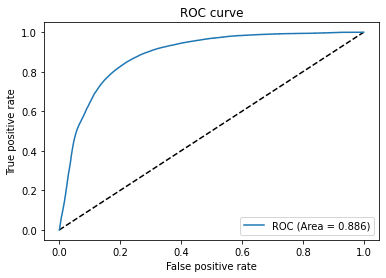

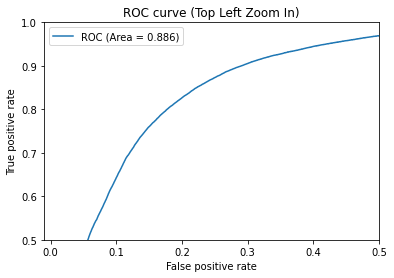

In [17]:
import matplotlib.pyplot as plt
%pylab inline

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='ROC (Area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(-0.01, 0.5)
plt.ylim(0.5, 1.0)
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(false_positive_rate, true_positive_rate, label='ROC (Area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (Top Left Zoom In)')
plt.legend(loc='best')
plt.show()

In [ ]:
'''   trainset = []
    valset = []
    train_annotation = []
    val_annotation = []
    
    for ID in range(55, len(graphy_keys)):
        #56
        #44
        #getting train pos
        traini_mask = datasets['graph_dataset'][ID].train_mask
        traini_pos = datasets['graph_dataset'][ID].pos
        for i in range(len(mask)):
            if(mask[i]==True):
                x, y = traini_pos[i]
                trainset.append((x, y))
        #patchinfo file
        global_P_info = datasets['patch_info'][ID]
        
        #getting val pos
        vali_mask = datasets['graph_dataset'][ID].val_mask
        vali_pos = datasets['graph_dataset'][ID].pos
        for i in range(len(mask)):
            if(mask[i]==True):
                x_1, y_2 = vali_pos[i]
                valset.append((x_1, y_2))
    #getting mask for train
        for x, y in trainset:

            x_info = global_P_info.loc[global_P_info['x'] == x]
            xy_info = x_info.loc[x_info['y'] == y]
            annot = (int(xy_info['blue']) or int(xy_info['green']))
            train_annotation.append(annot)
    #getting mask for val
        for x, y in valset:

            x_info = global_P_info.loc[global_P_info['x'] == x]
            xy_info = x_info.loc[x_info['y'] == y]
            annot = (int(xy_info['blue']) or int(xy_info['green']))
            val_annotation.append(annot)
    '''